In [1]:
import scipy.optimize
import scipy.stats
import sympy
import progressbar
sympy.init_printing(use_latex='mathjax')
%matplotlib inline
import IPython.display
import time

# Ant Colony Optimization for Energy Systems Research

This notebook explores using *Ant Colony Optimization* to solve the combinatorial optimization problem of optimally configuring a branch of an energy system. 

#NOTICE
The implementation in this document is flawed. First, my 'Ant Colony Optimization' optimization does in no way correspond to the state of the art. This combines badly with an error in the heuristic I used: since I did not include investment costs in the model, and since heat is significantly more valuable than electricity, large CHPPs are actually not economically beneficial (as the heuristic presumes). There is thus a much more profitable swarm that can be found using general purpose solvers (as we discovered when using Particle Swarm Optimization in Pol Duhr's BT).

To address this, towards the end an IP approach using Gurobi was added as an illustration. The performance of branch and bound seems much better than that of ant-searc - of course one would have to redo the whole calculation and adjust the implementation of the 'Ant' class to get a fair comparison.

I may adjust all of this at a later time - for now, this current version has to do, even though it is somewhat messy.

## Problem setting
This notebook illustrates the procedure on a simplified version of the decentralized energy provision problem the Energy Systems Group solves in the [CHPswarm project](http://www.chpswarm.ethz.ch): a list of buildings and their annual thermal energy demand (for space heating and warm water supply) is given. Each building is a potential installation site for a CHP plant - per our modeling paradigm, plants are designed so as to be completely (at all times and without the need for auxiliary heaters) satisfy the local heat demand. However, the number of production sites is limited: to ensure sustainability, individual plants may only burn biogas; the supply of which is finite. 

Now the challenge is to build a swarm, i.e. select a subset of production sites that, collectively, optimally utilize the biogas potential at minimal costs. These distinct objectives can be unified by combined by assuming that swarm operator buys all the available fuel ahead of time, so that being left with unburnt fuel at the end of the booking period becomes an economic inefficienc (the net worth of the fuel is not considered).

Note that many important aspects to the "CHP swarm" problem are ignored here, to keep this demonstration lean and focused on the actual Ant Colony Optimization. The results from this study should in no way be considered representative as an assessment of CHP technology or decentralized energy provision.

## Mathematical analysis
Abstractly speaking, the problem at hand is a variant of the [Knapsack problem](http://en.wikipedia.org/wiki/Knapsack_problem) (in short: which items to pack into a bag of finite volume, if each item has a given volume and worth, if the goal is to maximize the total worth of the cargo). 

## Model formulation

Modeling is kept simple in this example: the total thermal energy demand of each building is given via the vector _E_therm_ - which is just randomly generated assuming a normally distributed average heat demand per square meter and a normally distributed building surface area. We further assume that plants are designed so as to reach an annual operation time of $t_{op}=200h$ (outside that period, power is provided via an adiabatic buffer), which defines their nominal power rating. This is in accordance of our modeling paradigm of maximizing exergy efficiency; in other words, plants may not be run at part-load. Instead they operate at maximum efficiency (generally higher than the average thermal power demand), buffering the excess production  in a suitable storage device (generally a hot water tank). The maximum overall efficiency (fuel to electricity) follows the following approximation (see [annual report](files:/CHPPswarm_AnnualReport2014_20140903_SER.pdf)):

$$\eta_{el} = 2.43\cdot 10^{-2} \cdot \ln{\left(P_{el}\right)} + 2.42 \cdot 10^{-1} $$

Finally, it is assumed that $\eta_{th}=90\%$ of the waste heat stream from the engine are effectively available for heating. Now, the thermal output power $P_{th}$ is related to the annual thermal energy demand $E_{th}$ via the annual operation time $t_{op}$:

$$ \frac{E_{th}}{t_{op}} = P_{th} =  \frac{P_{el}}{\eta_{el}\left(P_{el}\right)} \cdot \left(1 - \eta_{el}\left(P_{el}\right)\right) \cdot \eta_{th} $$

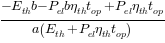

In [2]:
a, b, P_el = sympy.symbols("a b P_el ")
eta_el = a * sympy.log(P_el) + b

t_op, E_th, eta_th = sympy.symbols("t_op E_th eta_th")
P_th = P_el / eta_el * (1 - eta_el) * eta_th

sols = sympy.solve(sympy.Eq(P_th, E_th/t_op), sympy.log(P_el))
assert len(sols) == 1
sols[0]

The above expression was obtained by solving the equation for $P_{th}$ and $E_{th}$ for $\ln{P_{el}}$. The resulting equation is thus of the form $\ln{x} = f(x)$, where $f$ is a rational function in $x$. This can only be solved numerically. The following function uses [scipy.optimize.brentq](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.optimize.brentq.html#scipy.optimize.brentq) to solve the aforementioned equation ([numpy.vectorize](http://docs.scipy.org/doc/numpy/reference/generated/numpy.vectorize.html) as the input is going to be the energy demand vector _E_therm_).

In [2]:
def eta_el(P_el):
    return 2.43e-2*np.log(P_el) + 2.421e-1

def design_CHP(E_th, t_op=200*3600.):
    
    P_th_avg = E_th/t_op
    
    def f(P_el):
        P_th = P_el * (1/eta_el(P_el) - 1) * 0.9
        return P_th - P_th_avg
    
    return scipy.optimize.brentq(f, 1, 10e6)

design_CHP = np.vectorize(design_CHP)

With the above definitions computing the annual biogas demand is straight-forward:

In [3]:
def annual_biogas_demand(P_el, t_op=200*3600.):
    return P_el / eta_el(P_el) * t_op

With that, we are now able to find a suitable plant for a building whose annual thermal energy demand is known. What is more, we can also compute the amount of biogas that particular plant will need over the year. With that, we are able to start designing swarms.

## Sample building list

Of course first, we need a building list to actually design plants against. Here, purely synthetic data will be used, based on the assumptions:

* the annual energy demand per unit surface varies from $30 \ldots 300 \frac{kWh}{m^2}$
* its distribution skews towards lower values
* the surface are for various building types varies from $80 \ldots 2000 m^2$
* its distribution skews towards the lower end

In [4]:
def load_region(N_b=1e3):
    e_therm = scipy.stats.weibull_min(1.8, 0, 100).ppf(np.random.rand(N_b)) * 3.6e6
    A_build = scipy.stats.weibull_min(1.8, 0, 200).ppf(np.random.rand(N_b))
    return e_therm * A_build

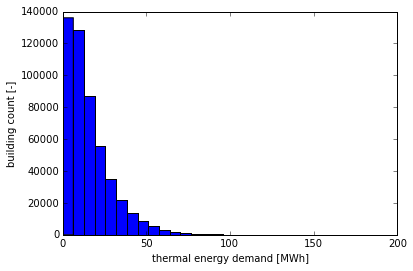

In [5]:
E_th = load_region(5e5)
ax = plt.subplot(111)
ax.hist(E_th / 3.6e9, bins=30)
ax.set_xlabel("thermal energy demand [MWh]")
ax.set_ylabel("building count [-]");

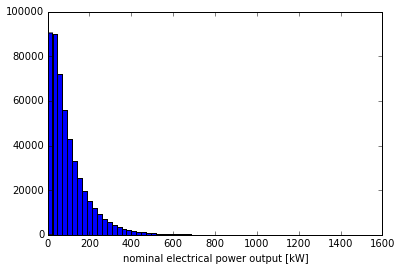

In [60]:
ax = plt.subplot(111)
ax.hist(design_CHP(E_th)*1e-3, bins=60)
ax.set_xlabel("nominal electrical power output [kW]");

## Optimization process

As mentioned in the introduction, the objective in the following will be to find a set of $N$ buildings that, when equipped with CHPPs both optimize total swarm operation costs (presuming all biogas has to be bought at the beginning of the period). Now we proceed to a formal mathematical formulation. We note:

* the index $i$ indicates that a quantity applies only to building $i$
* $E_{th,i}$ is the cumulative annual thermal energy demand of building $i$
* $P_{el,i}$ is the nominal electric output of the designed CHPP for building $i$
* $E_{el,i} = P_{el,i} \cdot t_{op}$ is the annual electricity output (electricity)
* $E_{fl,i} = E_{el,i} \cdot \eta_{el}\left( P_{el,_i}\right)^{-1}$ is the annual fuel demand (chemical energy)
* $E_{tot}$ is the totally available amount of biogas (chemical energy) to all buildings
* $\nu_i$, a binary variable, indicates whether a CHPP is installed in building $i$; note that, for this problem formulation, the vector $\nu$ of all $\nu_i$ is a complete description of a CHP swarm

The optimization target, as explained previously, is to maximize cost efficiency, assuming that the total available biogas potential $E_{tot}$ has to be bought in advance. Now let $c_{gas}$ be the biogas price, $c_{th}$ the heat energy retail price and $c_{el}$ the electricity retail price in monetary units per $kWh$. Then we can pose the problem:

$$ \max_{\nu} \left(\sum_i \nu_i \cdot \left(E_{el,i} \cdot c_{el} + E_{th,i} \cdot c_{th} \right)\right) - E_{tot} \cdot c_{gas}$$
$$\text{subject to: } \sum_i \nu_i \cdot E_{fl, i} \le E_{tot} $$

With this simple formulation it is rather straight-forward to predict the outcome: the above cost-balance depends directly on the conversion ratios of the individual CHPPs: the more efficient the average CHPP, the more revenue can be generated from the available biogas potential $E_{tot}$. Since the efficiency of the conversion process increases with nominal electrical power (which increases with average thermal power), the revenue of a swarm is higher the higher the absolute energy-demand of the reunited sites. The optimal swarm(s) is thus a compromise between maximizing the revenues with the highest $E_{th,i}$ yet keeping the portfolio diverse enough to minimize the amount of unused fuel at the end of the period.


In [6]:
t_op = 200 * 3600.

P_el = design_CHP(E_th, t_op=t_op)
E_el = P_el * t_op
E_fl = annual_biogas_demand(P_el, t_op=t_op)

Let's assume the biogas potential is enough to cover 10% of the demand:

In [7]:
E_tot = np.sum(E_fl) * 1e-1

In [55]:
def CHPswarm_fuel_demand(swarm):
    return np.sum(np.take(E_fl, swarm))

def CHPswarm_production_revenues(swarm, c_el=0.07, c_th=0.11):
    E_el_swarm = np.take(E_el, swarm)
    E_th_swarm = np.take(E_th, swarm)
    return (E_el_swarm * c_el + E_el_swarm * c_th) / 3.6e6
    
def CHPswarm_cost_balance(swarm, c_gas=0.05, **kwargs):
    return np.sum(CHPswarm_production_revenues(swarm, **kwargs)) - E_tot / 3.6e6 * c_gas

## Manual solution

To get an idea of what awaits, we try a manual optimization. The graph below shows the total fuel use of a swarm composed of the $N$ most powerful engines that can be installed.

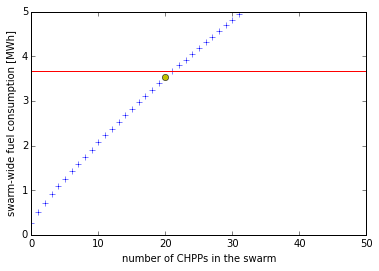

In [56]:
idx = np.argsort(-P_el)
ax = plt.subplot(111)
fl_tot = np.cumsum(E_fl[idx])
ax.plot(fl_tot/3.6e12, '+')
ax.plot([0, idx.shape[0]], [E_tot/3.6e12, E_tot/3.6e12], 'r')
ax.set_xlim([0, 50])
ax.set_xlabel("number of CHPPs in the swarm")
ax.set_ylabel("swarm-wide fuel consumption [MWh]")
ax.set_ylim([0, 5]);

idx_constr_opt = np.nonzero(fl_tot <= E_tot)[0][-1]
ax.plot(idx_constr_opt, fl_tot[idx_constr_opt]/3.6e12, 'yo');

The profits associated to such a configuration are shown below:

profits = 180749.02 CHF
fuel uzilization: 3656174.14 kWh of 3766347.03 kWh total (97.07 %)


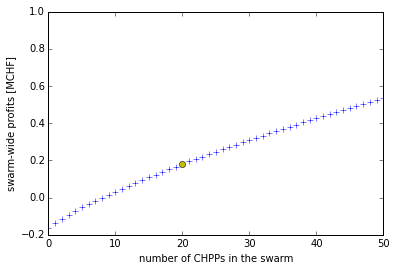

In [12]:
ax = plt.subplot(111)
profits = np.cumsum(CHPswarm_production_revenues(idx)) - E_tot / 3.6e6 * 0.05
ax.plot(profits * 1e-6, '+')
ax.set_xlabel("number of CHPPs in the swarm")
ax.set_ylabel("swarm-wide profits [MCHF]")
ax.set_xlim([0, 50])
ax.set_ylim([-.2, 1])
ax.plot(idx_constr_opt, profits[idx_constr_opt]*1e-6, 'yo');
print "profits = {:.2f} CHF".format(profits[idx_constr_opt])
manual_utilization = fl_tot[idx_constr_opt]/E_tot
print "fuel uzilization: {:.2f} kWh of {:.2f} kWh total ({:.2f} %)".format(fl_tot[idx_constr_opt]/3.6e6, E_tot/3.6e6, manual_utilization*100)

## Ant Colony Optimization (ACO)

For a general overview, and as a general reference for this section, see [Dorigo and Stülze, 2004](http://ieeexplore.ieee.org/servlet/opac?bknumber=6267250).

The Ant Colony Optimization algorithm mimmicks the food gathering behavior of an ant colony - a prominent example of swarm intelligence. Indeed, individually, ants are neither very smart, nor do they have a capacity to communicate complex information such as the shortest path to a food resource. Still, collectively, the logistic operations of an ant hill are highly structured and very efficient (in terms of distance travelled).

In the common model thinking, ants achieve this through swarm intelligence: initially, individual ants wander the surroundings of their colony more or less aimlessly (they forage). As soon as an ant encounters food, it gathers as much as it can carry and attempts to find its way back to the colony. In the following, we are going to assume that the ant remembers its path, and that it follows it back without deviation. On its way back, the ant secretes a special pheromon, leaving a chemical trail to the food resource. The pheromon entices another foraging ants to follow the same path - although they may deviate from it. Probabilistically, the liklihood of a foraging ant heading a certain direction increases with the pheromone concentration in that particular direction; but the pheromon evaporates over time. Given a large number of ants and enough time, this mechanism stabilizes along the most effective paths.

The above describes the classical ACO algorithm used to find the shortest path in a weighted graph.
Here, we try to essentially solve the Knapsack problem though, so the behavior of the "ants" has to be somewhat modified.
From a problem-oriented perspective, the ants become swarm configurators: starting from an initial "swarm of one", each ant sequentially includes one more buildings from the list, until no other building could be added without violating the biogas constraint (total swarm consumption exceeding $E_{tot}$). The result is a viable candidate solution, denoted by $J_k$, in terms of the set of all building indices making up the candidate solution of ant $k$.

As per the previous description, the ant now starts "heading back" to where it came from, deposing pheromone along the "way" $J_k$.  where $J_k$ is the candidate solution generated by ant $k$. Practically, (for now) this translates to the "pheromone balance" $\tau_i$ at each building $i$ included in the candidate solution being increased by an amount $\Delta_t$, proportional to the score (cost-revenue balance) of the candidate solution. Note that before any pheromone is added to any $\tau_i$, evaporation is modeled by the equation:
$$ \tau_{i}^{k + 1} = \tau_{i} \cdot (1 - \rho) $$

The decision of an "ant" to include a certain building over another is influenced by "pheromones": 
The latter is scored using the cost to revenue balance, and a "pheromon amount".

With all of that, we define the 'Ant' class, basically as an agent:

In [13]:
class Ant(object):
    
    def __init__(self, trail, initial_position=None):
        self.path = []
        if initial_position is not None:
            self.path.append(int(initial_position))
        self.trail = trail
        
    def worth(self):
        return CHPswarm_cost_balance(self.path)
    
    def chose_next_site(self):
        
        # viable next candidates
        E_fl_swarm = CHPswarm_fuel_demand(self.path)
        candidates = np.flatnonzero(E_fl_swarm + E_fl < E_tot)
        
        # eliminate already selected paths
        candidates = np.setdiff1d(candidates, self.path, assume_unique=True)
        
        # got a complete swarm if no more sites can be added
        if candidates.size==0:
            return
        
        # heuristic value --> just revenues:
        #   since operation times are identical for all, the largest plant always gets to produce most
        #   so there is no need to account for efficiency, e.g. by taking the fuel costs into consideration
        revenues = CHPswarm_production_revenues(candidates)
        
        # transition probabilities
        p = revenues * self.trail[candidates]
        p /= np.sum(p)
        
        return np.random.choice(candidates, size=1, p=p)
    
    def forage(self):
        next_site = self.chose_next_site()

        # nowhere to go = found a solution, give control back to ant system
        if next_site is None:
            raise FoundViableSolution(self)
        
        # continue foraging
        self.path.append(int(next_site))

class FoundViableSolution(Exception):
    def __init__(self, ant):
        self.path = frozenset(ant.path)
        self.score = ant.worth()
        
    

With individual ant behavior implemented, we now need to construct the "ant system" around it. The latter primarily consists of the shared "trail vector" $\tau$, storing the pheromone concentration assigned to (in this implementation) each site. Furthermore, the ant system takes care of the control flow, which comprises:

1. initialization of:
    1. the "trail", shared by all "ants", storing the pheromone levels (in this implementation, pheromone levels are attributed to individual sites, not the "edges" between a couple of buildings as often the case in ACO)
    2. $N_{ants}$ individual '_Ant_' instances, evenly distributed to random starting positions throughout the entire search space
2. repeat $N_{iter}$ times:
    1. for each ant, call the '_forage_' method; that causes the ant to either select one more site or return to its original position
    2. apply pheromone evaporation (let $\tau_i^z$ denote the pheromone level at building $i$ during iteration $z$):
$$ \tau_i^{z+1} = \tau_i^z \cdot (1 - \rho) $$
    3. possibly reassign ants that just found a solution to other starting positions if their solution score is low
3. select the ant with the highest scoring solution



In [14]:
def ant_system(N_ants=1000, N_iter=1000, trail=None, initial_pheromone_level=1e-3, rho=1e-2):
    
    # initialization: create trail and ants
    if trail is None:
        trail = np.ones(E_th.shape[0]) * initial_pheromone_level
    ants = [Ant(trail, i) for i in np.random.choice(trail.shape[0], size=N_ants)]
    solutions = dict()
    pb = progressbar.ProgressBar()
    pb.update(0)
    max_score = E_tot / 3.6e6 * 0.05
    
    for z in xrange(N_iter):
        
        # foraging
        for ant in ants:
            try:
                ant.forage()
            except FoundViableSolution as s:
                solutions[frozenset(ant.path)] = s.score
                trail[ant.path] += s.score / max_score
                ant.path = []  # reset ant to empty path --> picks starting node iteself

        # evaporation
        trail *= (1 - rho)
        
        pb.update((z + 1)/float(N_iter))
    pb.forced_update(1)
    return solutions

In [15]:
pheromones = np.ones(E_th.shape[0]) * 1e-3
trail = ant_system(trail=pheromones)

Simulation: [========================================] 100.0% - elapsed time: 251.3s

The following plot shows the pheromone levels of each node, as a function of its electrical nominal output power. IT is very clear that very powerful nodes are more desirable to have in a swarm. This is an indication that the optimization works!

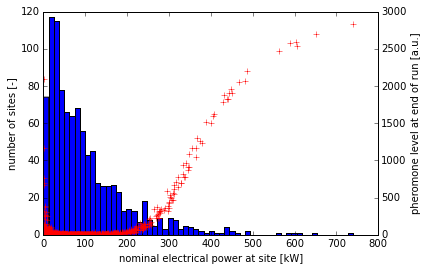

In [16]:
ax = plt.subplot(111)
ax2 = ax.twinx()
ax2.plot(P_el*1e-3, pheromones, 'r+')
ax.hist(design_CHP(E_th)*1e-3, bins=60)
ax.set_xlabel("nominal electrical power at site [kW]")
ax2.set_ylabel("pheromone level at end of run [a.u.]")
ax.set_ylabel("number of sites [-]");

## Results

So let's see what this produces. The best solution from all candidate solutions seems to indeed be the extremum on what could very well be a normal distribution - that's promising.

In [17]:
swarm, score = max(trail.iteritems(), key=lambda s: s[1])

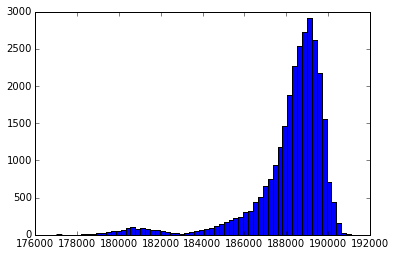

In [18]:
plt.hist(list(trail.itervalues()), bins=60);
score

Looking at the swarm composition, it seems to include a couple of larger devices, and a portfolio of smaller machines.

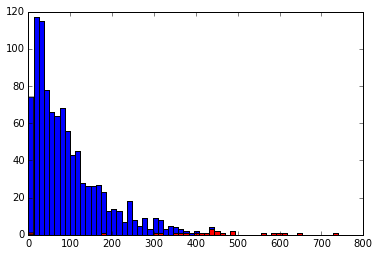

In [19]:
ax = plt.subplot(111)
ax.hist(P_el*1e-3, bins=60);
ax.hist(P_el[list(swarm)]*1e-3, bins=60, color="r");

If we try to build a swarm manually, starting with the biggest machines:

The fuel utilization seems to be very good:

In [20]:
print "fuel utilization: {:.2f} of {:.2f} kWh".format(CHPswarm_fuel_demand(list(swarm)) / 3.6e6, E_tot/3.6e6)


fuel utilization: 3766304.50 of 3766347.03 kWh


Now it seems that, with the current implementation, the swarm converges to larger and larger CHPPs, as the number of iterations is increased. It seems that the revenues it finds are actually higher than what the initial manual calculation indicated - stemming from a better fuel utilization:

In [30]:
s = "<table>"
s += "<tr><th>method</th><th>revenues</th><th>utilization</th></td>"
s += "<tr><td>manually</td><td>{:.2f} CHF</td><td>{:.4f} %</td></tr>".format(profits[idx_constr_opt], manual_utilization*100)
s += "<tr><td>ant-search</td><td>{:.2f} CHF</td><td>{:.4f} %</td></tr>".format(score, CHPswarm_fuel_demand(list(swarm))/E_tot*100)
IPython.display.HTML(s + "</table>")

NameError: name 'profits' is not defined

## Systematic investigation

With those promising results, it is time to look into computational efforts (although I have not at all profiled the code yet) and convergence. In the following, a number of simulations with increasing number of iterations will be run, wall-clock times will be measured and both fuel utilization and revenues will be used as quality indicators for the solutions. Note that evaluation is automated in the wrapper below:

In [ ]:
def ACO_run(**kwargs):
    t0 = time.clock()
    swarms = ant_system(**kwargs)
    score, swarm = 0, []
    if swarms:
        swarm, score = max(swarms.iteritems(), key=lambda s: s[1])   
    return np.array([score, CHPswarm_fuel_demand(list(swarm)), time.clock() - t0])

In [ ]:
results = np.array([ACO_run(N_iter=n) for n in np.logspace(2, 4, base=10, num=15, dtype=int)])

Simulation: [==                                      ]   5.0% - elapsed time: 117.5s - ETA: 2242.7s

In [ ]:
N_iter = np.logspace(2, 4, base=10, num=15, dtype=int)
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].plot(N_iter, results[:, 0]*1e-3, '+')
ax[0].plot([0, 10000], np.ones(2) * np.max(results[:, 0])*1e-3, 'c')
ax[0].set_title("swarm revenues [kCHF]")
ax[1].plot(N_iter, (E_tot-results[:, 1])/3.6e6, '+')
ax[1].set_title("remaining, unburnt fuel [kWh]")
ax[2].plot(N_iter, results[:, 2]/60., '+');
ax[2].set_title("wall-clock time [min]")
for i in xrange(3):
    ax[i].set_xlabel("number of iterations [-]")
    ax[i].set_xscale("log")

There is definitely convergence; a more or less stable result can be found after some 1000 iterations. The amount of unburnt fuel seems to fluctuate, however even $300 kWh$ is a minimal amount compared to $E_{tot}$. Nevertheless, also in the convergence plot (left) there is definitely some fluctuation beyond 1000 iterations. This is probably due to the stochastic nature of the algorithm.

## Closing thoughts

With fairly little effort, an Ant Colony Optimization based combinatorial problem solver was implemented in Python. With any optimizations having been done thus far, the solver was able to produce sensible results on a problem set involving 1000 buildings in under 5 minutes. That is very reasonable, considering that the the search space is theoretically composed of all possible subsets of $N=1000$ elements, i.e. the combinations of 1, 2, ... and 1000 buildings. In other words, a priori, the number of candidate solutions is a staggering:

In [ ]:
np.sum([scipy.misc.comb(1000, i+1) for i in xrange(1000)])

Now at its core, the ACO uses sampling of random subsets, very much as a brute-force approach would. However, by giving the "ants" heuristic knowledge of the problem, and of course by the swarm intelligence, the number of candidate solutions that have to be investigated comes down to several 10'000:

In [ ]:
print "{} candidate solutions were explored".format(len(trail))

It is worth noting that the ACO implementation was able to improve on the solution of our initial heuristic approach, which was maximizing revenues by only chosing the largest, i.e. most efficient, CHP production sites. The ACO seems to do the same, but it further includes a few mcuh smaller plants to simultaneously maximize fuel utilization. 

It was feared that this might destabilize the solver. Indeed there are many, more or less equivalent small sites to chose from. That apparently did not hinder convergence, although it may explain the fluctuations after convergence at $N_{iter} > 10^3$.

In any case, ACO appears to be a very attractive method for solving our energy-system composition combinatorial optimization problem. Of course some further testing is mandated, as well as the exploration of Particle Swarm Optimization.


#Addendum: using branch and bound (Gurobi 6.0)
According to Paschos's "concepts of combinatorial optimization", the integer Knapsack problem can be efficiently solved using the "branc and bounds" approach. It traverses the binary decision tree constructed around the $N$ binary decision variables $x_i$, using a relaxation of the original integer problem (decision variables $x_i \in \{0, 1\}$) to a constrained linear problem (decision variables $\tilde{x}_i \in \[0, 1\]$) as a metric.

In [8]:
import gurobipy as grb
m = grb.Model("energy_knapsack")

# site selection indicator: x_i = 1 --> CHPP at site i
X = [m.addVar(0.0, 1.0, vtype=grb.GRB.BINARY, name="x_{}".format(i)) for i in xrange(E_fl.shape[0])]
m.update()

# objective: gas expenditures + revenues from heat and electricity sales
c_el=0.07
c_th=0.11
c_gas=0.05
rev = (E_el * c_el + E_th * c_th) / 3.6e6
m.setObjective(- E_tot / 3.6e6 * c_gas + grb.quicksum(rev[i] * x for i, x in enumerate(X)))
m.update()

# constraint: total amount of biogas
m.addConstr(grb.quicksum(E_fl[i] * x for i, x in enumerate(X)) <= E_tot)

# run model
m.modelSense = grb.GRB.MAXIMIZE
m.optimize()

Optimize a model with 1 rows, 500000 columns and 500000 nonzeros
Coefficient statistics:
  Matrix range    [1e+07, 2e+12]
  Objective range [4e-01, 4e+04]
  Bounds range    [1e+00, 1e+00]
  RHS range       [7e+15, 7e+15]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 2.5032e+08
Presolve time: 3.26s
Presolved: 1 rows, 500000 columns, 500000 nonzeros
Variable types: 0 continuous, 500000 integer (500000 binary)

Root relaxation: objective 2.524177e+08, 1 iterations, 0.21 seconds
Total elapsed time = 18.50s

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2.5242e+08    0    1 2.5032e+08 2.5242e+08  0.84%     -   18s
H    0     0                    2.524177e+08 2.5242e+08  0.00%     -   21s

Explored 0 nodes (1 simplex iterations) in 21.34 seconds
Thread count was 2 (of 4 available

In [25]:
print "successfull" if m.status == grb.GRB.status.OPTIMAL else "failed"

successfull


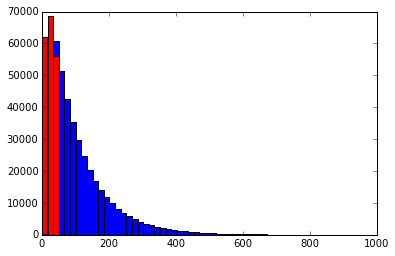

In [25]:
swarm = np.array([bool(x.X) for x in X])
ax = plt.subplot(111)
bins = np.linspace(0, np.ceil(np.max(P_el)*1e-6)*1e3, 120)
ax.hist(P_el*1e-3, bins=bins)
ax.hist(P_el[swarm]*1e-3, bins=bins, color="r");
ax.set_xlim([0, 1000]);

In [34]:
E_swarm = np.dot(E_fl, swarm)
print "fuel utilization: {:.2f} of {:.2f} kWh ({:.2f} kWh or {:.7f} %)".format(E_swarm / 3.6e6, E_tot/3.6e6, (E_tot - E_swarm) / 3.6e6, E_swarm/E_tot * 100)

fuel utilization: 1873345795.01 of 1873345919.66 kWh (124.65 kWh or 99.9999933 %)


Within less than 60s, Gurobi finds the actual optimal solution out of a set of 50'000 potential sites. Performancewise Gurobi is thus lightyears ahead of ant-search and PSO - for this particular problem. Nevertheless, introducing non-linearities or complex dynamic behavior (which will be required at a later stage of the project) still may be much simpler with a metaheuristic. So I do not think that we will abandon metaheuristics for now. In particular hybrid approaches could prove extremely useful, e.g. running linearized models within Gurobi (or CVXGEN) as a heuristic, or optimizing parameters of a Gurobi model using an external metaheuristic.